In [11]:
from paths import *
import pandas as pd
import numpy as np
import os
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import joblib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import multiprocessing as mp
import warnings


In [2]:
NCORES = 8

In [3]:

warnings.filterwarnings("ignore", message="`distplot` is a deprecated function")
warnings.filterwarnings("ignore", message="DeprecationWarning")

 


In [22]:
def glm_model(data_, analyte_, sample_):
    data_analyte = data_[data_["Analyte"] == analyte_]
    le = LabelEncoder()
    data_analyte.loc[:, 'Disease_label'] = le.fit_transform(data_analyte['Group Name'])
    data_analyte.loc[:, 'Gender_label'] = le.fit_transform(data_analyte['Gender'])
    data_analyte.loc[:, 'site'] = data_analyte.loc[:, 'Client Sample ID'].str[:3]
    data_analyte = data_analyte[["Result", "Disease_label", "Age", "BMI", "Gender_label", "site", "house"]]
    X = sm.add_constant(data_analyte[['Age', 'BMI', 'Gender_label', 'Disease_label']])
    site_dummies = pd.get_dummies(data_analyte['site'], prefix='site', drop_first=True)
    house_dummies = pd.get_dummies(data_analyte['house'], prefix='house', drop_first=True)
    X = pd.concat([X, site_dummies, house_dummies], axis=1)
    model = sm.GLM(data_analyte['Result'], X, family=sm.families.Gamma(link=sm.families.links.log()))
#     model = sm.GLM(data_analyte['Result'], X, family=sm.families.Gaussian(link=sm.families.links.identity()))
    mdf = model.fit()
    out_dict = {}
    out_dict["analyte"] = analyte_
    out_dict["sample"] = sample_
    out_dict["patient_sample_count"] = data_analyte.shape[0]
    out_dict["model"] = mdf
    return out_dict 

def get_model_parallel(data_, analytes_, sample_):
    data_list = [data_]*len(analytes_)
    analytes_list = list(analytes_)
    sample_list = [sample_]*len(analytes_)
    arg_list = list(zip(data_list, analytes_list, sample_list))
    p = mp.Pool(NCORES)
    model_list = p.starmap(glm_model, arg_list)
    p.close()
    p.join()
    return model_list

In [5]:
sample = "feces"

filename = SHORT_CHAIN_FATTY_ACID_DATA_FILENAME
mapping_filename = "short_chain_fatty_acid_spoke_map.csv"
file_path = os.path.join(DATA_ROOT_PATH, filename)
mapping_filepath = os.path.join(OUTPUT_PATH, mapping_filename)
data = pd.read_excel(file_path, engine='openpyxl')
data = data[data["Client Matrix"]==sample]
mapping_data = pd.read_csv(mapping_filepath)
analytes = mapping_data["name"].unique()
data.head()

,Unique Tube Label ID,Client Sample ID,Client Matrix,Sample Description,Group Name,Treatment,Gender,Age,BMI,Race / Ethnicity,Analyte,Result,Unit,Dilution Factor,LLOQ,ULOQ,Analysis Comment
0,FB06341898,71801-0010,feces,Fecal sample,MS,Off,F,50.0,18.645344,Caucasian/Hispanic,2-Methylbutyric acid,159.251,µg/g,1,5,2000,NaN
1,FB06341896,71801-0027,feces,Fecal sample,MS,Treated,M,29.0,23.038752,Caucasian/Hispanic,2-Methylbutyric acid,171.655,µg/g,1,5,2000,NaN
2,FB06341882,71801-0022,feces,Fecal sample,MS,Treated,F,33.0,17.474717,Caucasian/Hispanic,2-Methylbutyric acid,26.897,µg/g,1,5,2000,NaN
3,FB06341906,71801-0017,feces,Fecal sample,MS,Treated,F,53.0,25.721032,Caucasian/Hispanic,2-Methylbutyric acid,116.243,µg/g,1,5,2000,NaN
4,FB06341902,71802-0027,feces,Fecal sample,Control,Control,F,32.0,18.426534,Caucasian/Hispanic,2-Methylbutyric acid,48.814,µg/g,1,5,2000,NaN


In [ ]:
data.loc[:, 'house'] = (data['Client Sample ID'].str[:3] + data['Client Sample ID'].str[-4:])

data_exclude_outlier_threshold_column = data.drop("Analysis Comment", axis=1)
house_to_exclude = data_exclude_outlier_threshold_column[data_exclude_outlier_threshold_column.isna().any(axis=1)].house.values
data_nan_removed = data[~data["house"].isin(house_to_exclude)]

data_outlier_removed = data_nan_removed[data_nan_removed["Analysis Comment"].isna()]
data_outlier_removed.drop("Analysis Comment", axis=1, inplace=True)

#Removing unpaired house for each analyte after removing the outliers, so that we get paired MS and control patients

#Step 1: Group by "Analyte" and "house" and count the number of occurrences of each group
group_counts = data_outlier_removed.groupby(['Analyte', 'house']).size()

#Step 2: Get the list of index values where the count is 2
valid_index = group_counts[group_counts == 2].reset_index().set_index(['Analyte', 'house']).index

#Step 3: Filter the DataFrame to keep only the rows with paired "house" values for each "Analyte"
data_outlier_removed = data_outlier_removed.set_index(['Analyte', 'house']).loc[valid_index].reset_index()



## Plotting the final count of patient samples after pre-processing

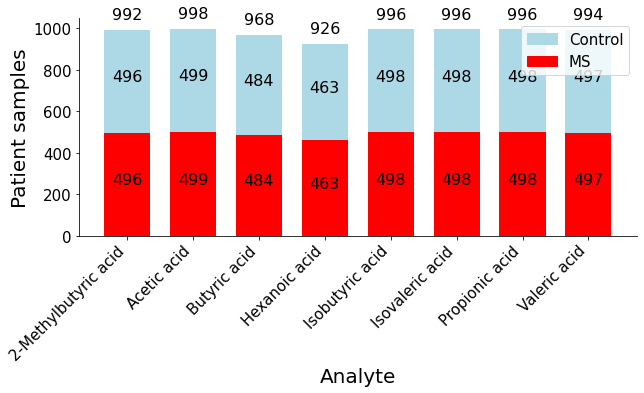

In [7]:
fontsize = 20
figsize = (10,4)

fig = plt.figure(figsize=figsize)

ax = plt.gca()

# group the data by analyte and group name, and get the unique count of unique tube label ID
grouped = data_outlier_removed.groupby(['Analyte', 'Group Name'])['Unique Tube Label ID'].nunique().reset_index()

# pivot the table to get the count for each group name as separate columns
pivoted = grouped.pivot(index='Analyte', columns='Group Name', values='Unique Tube Label ID')

# create the bar plot for each analyte
for i, analyte in enumerate(pivoted.index):
    ms_count = pivoted.loc[analyte, 'MS']
    control_count = pivoted.loc[analyte, 'Control']
    total_count = ms_count + control_count    
    
    # plot red bar for MS count
    ax.bar(i, ms_count, color='red', width=0.7, align='center')
    # plot light blue bar for control count
    ax.bar(i, control_count, color='lightblue', width=0.7, align='center', bottom=control_count)
    # add the total count above the bars
    ax.text(i, total_count+50, f'{total_count}', ha='center', fontsize=fontsize-4)
    # add the count for each group name on top of the bars
    ax.text(i, control_count/2, f'{control_count}', ha='center', fontsize=fontsize-4, color='black')
    ax.text(i, control_count+ms_count/2, f'{ms_count}', ha='center', fontsize=fontsize-4, color='black')

# set the x-axis labels to be the analyte names
ax.set_xticks(range(len(pivoted.index)))
ax.set_xticklabels(pivoted.index, fontsize=12, rotation=45, ha='right')

# set the y-axis label and tick labels
# ax.set_ylabel('Unique Tube Label ID Count', fontsize=12)
ax.tick_params(axis='y', labelsize=12)

# remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# set the x label and title
plt.xlabel('Analyte',fontsize=fontsize)
plt.ylabel('Patient samples',fontsize=fontsize)

plt.xticks(rotation=45, fontsize=fontsize-5)
plt.yticks(fontsize=fontsize-5)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# add legend box
blue_patch = mpatches.Patch(color='lightblue', label='Control')
red_patch = mpatches.Patch(color='red', label='MS')
plt.legend(handles=[blue_patch, red_patch], fontsize=fontsize-5)
plt.show()

# print('Saving the figure ...')
# fig_filename = os.path.join(OUTPUT_PATH, "figures", "shortChain_fattyAcid_patient_counts_{}_sample.svg".format(sample))
# fig.savefig(fig_filename, format='svg', bbox_inches='tight')


## Distribution of analyte concentration

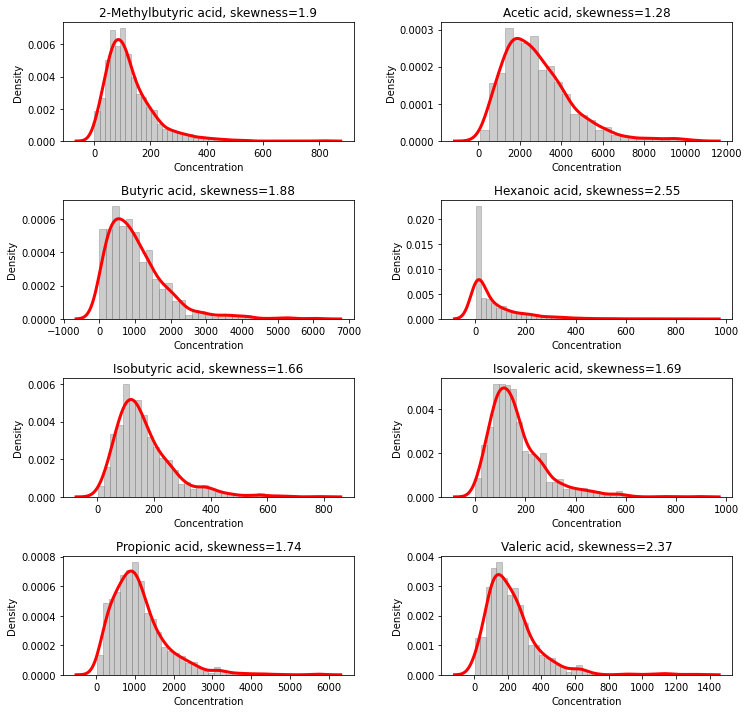

In [8]:
# Create a 4x4 subplot grid
fig, axes = plt.subplots(4, 2, figsize=(12, 12))

# Flatten the subplot grid for easier indexing
axes = axes.flatten()

df = data

# Loop over the analyte values and plot their distributions
for i, analyte in enumerate(df['Analyte'].unique()):
    # Select the data for the current analyte
    subset = df[df['Analyte'] == analyte]['Result']
    
    # Compute the skewness of the data
    skewness = round(subset.skew(), 2)
    
    # Plot the histogram and kde plot
    sns.distplot(subset, hist=True, kde=True, ax=axes[i], 
                 kde_kws={'color': 'r', 'lw': 3},
                 hist_kws={'color': 'gray', 'edgecolor': 'gray', 'linewidth': 1})
    
    # Set the title and axis labels
    axes[i].set_title(f"{analyte}, skewness={skewness}")
    axes[i].set_xlabel('Concentration')
    axes[i].set_ylabel('Density')

# Remove the unused subplots
for i in range(8, len(axes)):
    fig.delaxes(axes[i])
    
# Adjust the spacing between the subplots
plt.subplots_adjust(wspace=0.3, hspace=0.5)

# Show the plot
plt.show()

# print('Saving the figure ...')
# fig_filename = os.path.join(OUTPUT_PATH, "figures", "distribution_of_shortChain_fattyAcid_concentration_full_data_{}_sample.svg".format(sample))
# fig.savefig(fig_filename, format='svg', bbox_inches='tight')


## Distribution of analyte concentration - after removing outliers

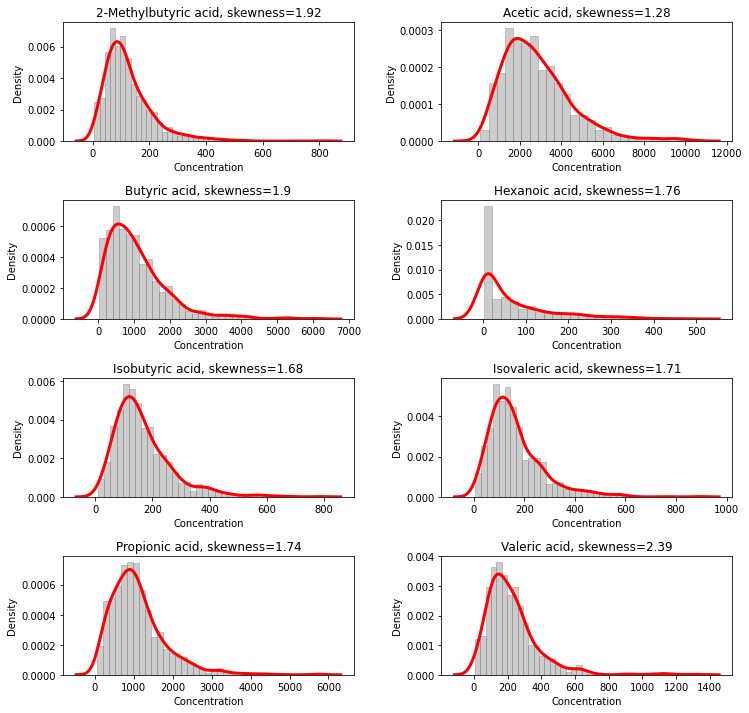

In [9]:
# Create a 4x4 subplot grid
fig, axes = plt.subplots(4, 2, figsize=(12, 12))

# Flatten the subplot grid for easier indexing
axes = axes.flatten()

df = data_outlier_removed

# Loop over the analyte values and plot their distributions
for i, analyte in enumerate(df['Analyte'].unique()):
    # Select the data for the current analyte
    subset = df[df['Analyte'] == analyte]['Result']
    
    # Compute the skewness of the data
    skewness = round(subset.skew(), 2)
    
    # Plot the histogram and kde plot
    sns.distplot(subset, hist=True, kde=True, ax=axes[i], 
                 kde_kws={'color': 'r', 'lw': 3},
                 hist_kws={'color': 'gray', 'edgecolor': 'gray', 'linewidth': 1})
    
    # Set the title and axis labels
    axes[i].set_title(f"{analyte}, skewness={skewness}")
    axes[i].set_xlabel('Concentration')
    axes[i].set_ylabel('Density')

# Remove the unused subplots
for i in range(8, len(axes)):
    fig.delaxes(axes[i])
    
# Adjust the spacing between the subplots
plt.subplots_adjust(wspace=0.3, hspace=0.5)

# Show the plot
plt.show()

# print('Saving the figure ...')
# fig_filename = os.path.join(OUTPUT_PATH, "figures", "distribution_of_shortChain_fattyAcid_concentration_pre_processed_data_{}_sample.svg".format(sample))
# fig.savefig(fig_filename, format='svg', bbox_inches='tight')


## Applying log-transformation to the analyte concentration

In [16]:
data_log_transformed = data.copy()
for analyte in analytes:
    analyte_concentration = data_log_transformed[data_log_transformed["Analyte"] == analyte]["Result"].values
    data_log_transformed.loc[data_log_transformed["Analyte"] == analyte, "Result"] = np.log(analyte_concentration)
    
data_nan_removed_log_transformed = data_nan_removed.copy()
for analyte in analytes:
    analyte_concentration = data_nan_removed_log_transformed[data_nan_removed_log_transformed["Analyte"] == analyte]["Result"].values
    data_nan_removed_log_transformed.loc[data_nan_removed_log_transformed["Analyte"] == analyte, "Result"] = np.log(analyte_concentration)
        
data_outlier_removed_log_transformed = data_outlier_removed.copy()
for analyte in analytes:
    analyte_concentration = data_outlier_removed_log_transformed[data_outlier_removed_log_transformed["Analyte"] == analyte]["Result"].values
    data_outlier_removed_log_transformed.loc[data_outlier_removed_log_transformed["Analyte"] == analyte, "Result"] = np.log(analyte_concentration)
    

## Distribution of log transformed analyte concentration

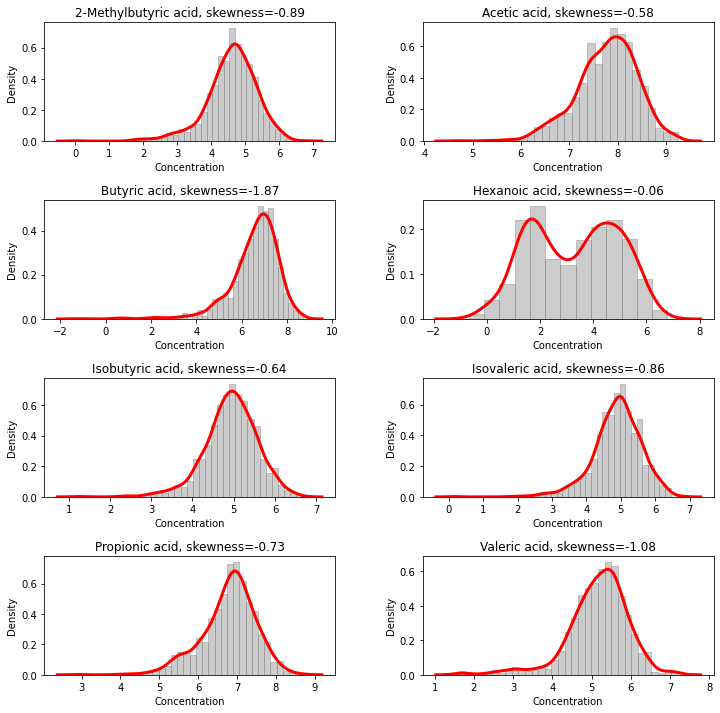

In [17]:
# Create a 4x4 subplot grid
fig, axes = plt.subplots(4, 2, figsize=(12, 12))

# Flatten the subplot grid for easier indexing
axes = axes.flatten()

df = data_log_transformed

# Loop over the analyte values and plot their distributions
for i, analyte in enumerate(df['Analyte'].unique()):
    # Select the data for the current analyte
    subset = df[df['Analyte'] == analyte]['Result']
    
    # Compute the skewness of the data
    skewness = round(subset.skew(), 2)
    
    # Plot the histogram and kde plot
    sns.distplot(subset, hist=True, kde=True, ax=axes[i], 
                 kde_kws={'color': 'r', 'lw': 3},
                 hist_kws={'color': 'gray', 'edgecolor': 'gray', 'linewidth': 1})
    
    # Set the title and axis labels
    axes[i].set_title(f"{analyte}, skewness={skewness}")
    axes[i].set_xlabel('Concentration')
    axes[i].set_ylabel('Density')

# Remove the unused subplots
for i in range(8, len(axes)):
    fig.delaxes(axes[i])
    
# Adjust the spacing between the subplots
plt.subplots_adjust(wspace=0.3, hspace=0.5)

# Show the plot
plt.show()

# print('Saving the figure ...')
# fig_filename = os.path.join(OUTPUT_PATH, "figures", "distribution_of_shortChain_fattyAcid_concentration_full_data_{}_sample.svg".format(sample))
# fig.savefig(fig_filename, format='svg', bbox_inches='tight')


## Distribution of log transformed analyte concentration - after removing outliers

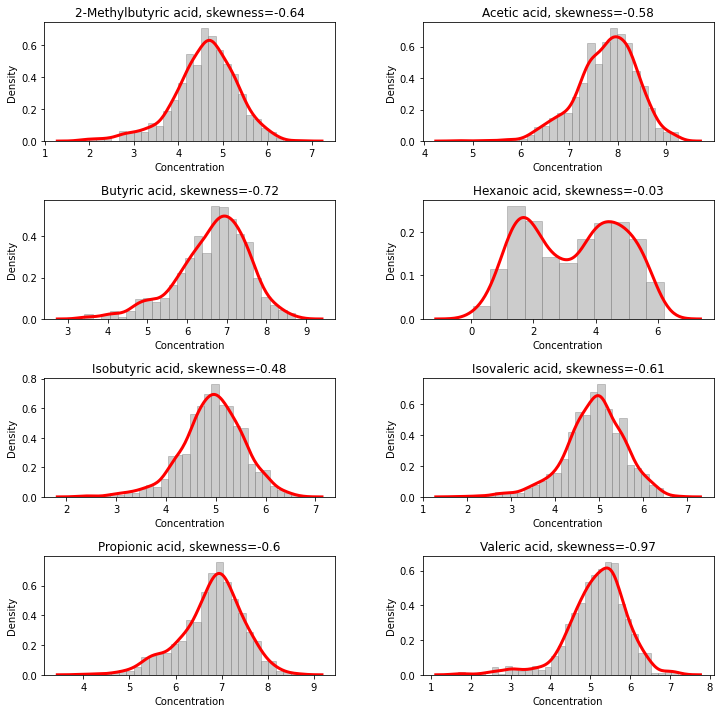

In [18]:
# Create a 4x4 subplot grid
fig, axes = plt.subplots(4, 2, figsize=(12, 12))

# Flatten the subplot grid for easier indexing
axes = axes.flatten()

df = data_outlier_removed_log_transformed

# Loop over the analyte values and plot their distributions
for i, analyte in enumerate(df['Analyte'].unique()):
    # Select the data for the current analyte
    subset = df[df['Analyte'] == analyte]['Result']
    
    # Compute the skewness of the data
    skewness = round(subset.skew(), 2)
    
    # Plot the histogram and kde plot
    sns.distplot(subset, hist=True, kde=True, ax=axes[i], 
                 kde_kws={'color': 'r', 'lw': 3},
                 hist_kws={'color': 'gray', 'edgecolor': 'gray', 'linewidth': 1})
    
    # Set the title and axis labels
    axes[i].set_title(f"{analyte}, skewness={skewness}")
    axes[i].set_xlabel('Concentration')
    axes[i].set_ylabel('Density')

# Remove the unused subplots
for i in range(8, len(axes)):
    fig.delaxes(axes[i])
    
# Adjust the spacing between the subplots
plt.subplots_adjust(wspace=0.3, hspace=0.5)

# Show the plot
plt.show()

# print('Saving the figure ...')
# fig_filename = os.path.join(OUTPUT_PATH, "figures", "distribution_of_shortChain_fattyAcid_concentration_full_data_{}_sample.svg".format(sample))
# fig.savefig(fig_filename, format='svg', bbox_inches='tight')


## GLM without outliers

In [ ]:
%%time

model_without_outlier_list = get_model_parallel(data_outlier_removed, analytes, sample)
joblib.dump(model_without_outlier_list, os.path.join(OUTPUT_PATH, "GLM_shortChain_fattyAcid_without_outlier_sample_{}.joblib".format(sample)))




## GLM without outliers - MS treated

In [ ]:
%%time

house_to_include = data_outlier_removed[data_outlier_removed.Treatment=="Treated"]["house"].unique()
data_outlier_removed_ms_treated = data_outlier_removed[data_outlier_removed.house.isin(house_to_include)]

model_without_outlier_ms_treated_list = get_model_parallel(data_outlier_removed_ms_treated, analytes, sample)
joblib.dump(model_without_outlier_ms_treated_list, os.path.join(OUTPUT_PATH, "GLM_shortChain_fattyAcid_without_outlier_ms_treated_sample_{}.joblib".format(sample)))




## GLM without outliers - MS not treated

In [ ]:
%%time

house_to_include = data_outlier_removed[data_outlier_removed.Treatment=="Off"]["house"].unique()
data_outlier_removed_ms_not_treated = data_outlier_removed[data_outlier_removed.house.isin(house_to_include)]

model_without_outlier_ms_not_treated_list = get_model_parallel(data_outlier_removed_ms_not_treated, analytes, sample)
joblib.dump(model_without_outlier_ms_not_treated_list, os.path.join(OUTPUT_PATH, "GLM_shortChain_fattyAcid_without_outlier_ms_not_treated_sample_{}.joblib".format(sample)))



## GLM with outliers

In [ ]:
%%time

model_with_outlier_list = get_model_parallel(data_nan_removed, analytes, sample)
joblib.dump(model_with_outlier_list, os.path.join(OUTPUT_PATH, "GLM_shortChain_fattyAcid_with_outlier_sample_{}.joblib".format(sample)))




## GLM with outliers - MS treated

In [ ]:
%%time

house_to_include = data_nan_removed[data_nan_removed.Treatment=="Treated"]["house"].unique()
data_nan_removed_ms_treated = data_nan_removed[data_nan_removed.house.isin(house_to_include)]

model_with_outlier_ms_treated_list = get_model_parallel(data_nan_removed_ms_treated, analytes, sample)
joblib.dump(model_with_outlier_ms_treated_list, os.path.join(OUTPUT_PATH, "GLM_shortChain_fattyAcid_with_outlier_ms_treated_sample_{}.joblib".format(sample)))



## GLM with outliers - MS not treated

In [ ]:
%%time

house_to_include = data_nan_removed[data_nan_removed.Treatment=="Off"]["house"].unique()
data_nan_removed_ms_not_treated = data_nan_removed[data_nan_removed.house.isin(house_to_include)]

model_with_outlier_ms_not_treated_list = get_model_parallel(data_nan_removed_ms_not_treated, analytes, sample)
joblib.dump(model_with_outlier_ms_not_treated_list, os.path.join(OUTPUT_PATH, "GLM_shortChain_fattyAcid_with_outlier_ms_not_treated_sample_{}.joblib".format(sample)))

